In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score

In [3]:
# ----------------------- Data loading and preprocessig ---------------------- #

file_train = 'ZipDigits.train'
file_test = 'ZipDigits.test'


def read_data(file_name):
    digits = []
    images = []
    with open(file_name, 'r') as f:
        for line in f:
            line = line.strip().split(' ')
            line = [float(i) for i in line]
            digit = int(line[0])
            data = line[1:]
            images.append(data)
            digits.append(digit)
    return np.array(images), np.array(digits)


def get_features(file_name):
    images, digits = read_data(file_name)
    images = images.reshape(-1, 16, 16)
    images = (images + 1) / 2  # normalize between [0,1]


    # Extract feature
    intensities = images.reshape(-1, 16 * 16).mean(axis=-1)
    symmetry = np.power(images[..., ::-1] - images,
                        2).reshape(images.shape[0], -1).mean(axis=-1)

    ind_1 = (digits == 1)
    ind_n1 = (digits != 1)
    labels = np.zeros(digits.shape[0])
    labels[ind_1] = 1
    labels[ind_n1] = -1
    features = np.concatenate((intensities[:, None], symmetry[:, None]),
                              axis=1)
    return features, labels


# ------------------------------ train features ------------------------------ #
features_train, labels_train = get_features(file_train)

# ------------------------------- test features ------------------------------ #
features_test, labels_test = get_features(file_test)

# Combine the training and test data into a single data set.
features = np.concatenate((features_train, features_test), axis=0)
labels = np.concatenate((labels_train, labels_test), axis=0)

# normalize features between [-1, 1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((-1, 1))
features = scaler.fit_transform(features)

# Randomly select 300 data points for your data set D. Put the remaining data into a test set Dtest
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, train_size=300, random_state=0)

assert features_train.shape[0] == 300

/usr/lib/python3/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# (1)
### Use the 8th order Legendre polynomial feature transform to compute

In [4]:
from scipy.special import legendre

# 0 1 2 3
# 0 1 2 3

# 1 + 2 + 3 + ... + (n+1) = (n+1)(n+2)/2


def get_feat_transform_legenre(features, degree=8):
    """
    Transform features using Legendre polynomial
    """
    n_features = features.shape[1]
    n_samples = features.shape[0]

    x = features[:, 0]
    y = features[:, 1]

    n_features_transformed = int((degree + 1) * (degree + 2) / 2)
    features_transformed = np.zeros((n_samples, n_features_transformed))

    counter = 0
    for i in range(degree):
        for j in range(degree):
            if i + j <= degree:
                features_transformed[:, counter] = legendre(i)(x) * legendre(j)(
                    y)  # L_i(x) * L_j(y)
                counter += 1

    return features_transformed

# get transformed features
feat_tfm = get_feat_transform_legenre(features_train, degree=8)
print(f"Dimension of Z: {feat_tfm.shape[1]}")

feat_tfm_test = get_feat_transform_legenre(features_test, degree=8)

Dimension of Z: 45


# (2)
### Give a plot of the decision boundary for the resulting weights produced by the linear regression algorithm without any regularization (λ = 0). Do you think there is overfitting or underfitting?


In [7]:
x = np.linspace(0, 0.7, 100)
y = np.linspace(0, 0.5, 100)

X, Y = np.meshgrid(x, y)

XY = np.c_[X.ravel(), Y.ravel()]





(100, 100)

In [14]:
# Function for plotting decision boundary

def calc_f(x, y, w):
    xy = np.c_[x.ravel(), y.ravel()]
    feat = get_feat_transform_legenre(xy, degree=8)
    y_pred = np.dot(feat, w)
    y_pred = y_pred.reshape(x.shape)
    return y_pred


def plot_decision_boundary(w):

    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)

    X, Y = np.meshgrid(x, y)
    Z = calc_f(X, Y, w)

    # ------------------------------ train features ------------------------------ #
    plt.figure(1)
    plt.scatter(features_train[:, 0][labels_train == 1],
                features_train[:, 1][labels_train == 1],
                c='b',
                marker='o',
                label='1')
    plt.scatter(features_train[:, 0][labels_train == -1],
                features_train[:, 1][labels_train == -1],
                c='r',
                marker='x',
                label='not 1')

    plt.contour(X, Y, Z, levels=[0], label='Decision boundary')

    plt.legend()

    plt.xlabel('Intensity')
    plt.ylabel('Symmetry')
    plt.title('Train data')


E_train: 0.12438391471650977
E_test: 0.9578396638628325


/usr/lib/python3/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label'
  s)


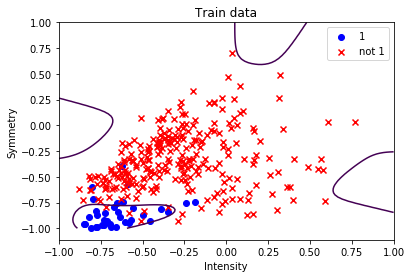

In [20]:
Z = feat_tfm
w_lin = np.linalg.pinv(Z.transpose() @ Z) @ Z.transpose() @ labels_train
y_pred = np.dot(Z, w_lin)

e_train = np.mean(np.power(y_pred - labels_train, 2))

# test error
y_pred_test = np.dot(feat_tfm_test, w_lin)
e_test = np.mean(np.power(y_pred_test - labels_test, 2))


print(f"E_train: {e_train}")
print(f"E_test: {e_test}")

plot_decision_boundary(w_lin)

E_train: 0.13178789857337644
E_test: 0.12298522546179252


/usr/lib/python3/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label'
  s)


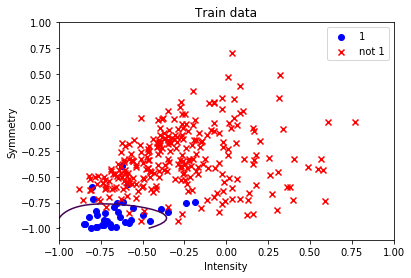

In [21]:
Z = feat_tfm
lamb = 2
w_reg = np.linalg.pinv(Z.transpose() @ Z + lamb * np.eye(Z.shape[1]) ) @ Z.transpose() @ labels_train
y_pred = np.dot(Z, w_reg)

e_train = np.mean(np.power(y_pred - labels_train, 2))

# test error
y_pred_test = np.dot(feat_tfm_test, w_reg)
e_test = np.mean(np.power(y_pred_test - labels_test, 2))

print(f"E_train: {e_train}")
print(f"E_test: {e_test}")

plot_decision_boundary(w_reg)


# (4)
###  Cross Validation

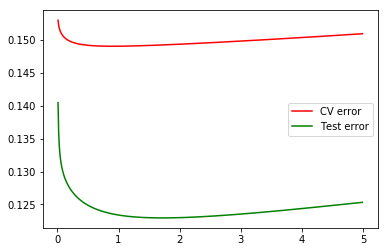

In [22]:
lambs = np.arange(0, 5, 0.01)
e_cvs = np.zeros(lambs.shape[0])
e_tests = np.zeros(lambs.shape[0])

for i, lamb in enumerate(lambs):
    _ww = np.linalg.pinv(Z.transpose() @ Z +
                           lamb * np.eye(Z.shape[1])) @ Z.transpose()
    w_reg = _ww @ labels_train
    H_lamb = Z @ _ww

    y_pred = np.dot(Z, w_reg)

    e_cv = np.power((y_pred - labels_train) / (1 - H_lamb.diagonal()), 2).mean()
    e_cvs[i] = e_cv

    y_pred_test = np.dot(feat_tfm_test, w_reg)
    e_test = np.power((y_pred_test - labels_test), 2).mean()
    e_tests[i] = e_test

plt.plot(lambs[1:], e_cvs[1:], label='CV error', color='r')
plt.plot(lambs[1:], e_tests[1:], label='Test error', color='g')
plt.legend()

# (5)

### Use the cross validation error to pick the best value of λ, call it λ*. Give a plot of the decision boundary for the weights w_reg(λ∗).

E_train: 0.12975005257107608
E_test: 0.12353476773699112


/usr/lib/python3/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label'
  s)


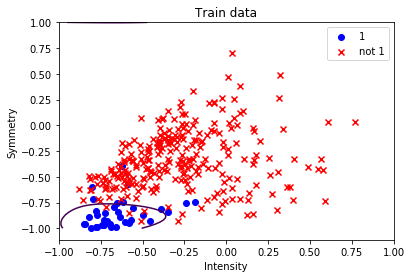

In [23]:
lamb_prime = lambs[np.argmin(e_cvs)]
lamb = lamb_prime
w_reg = np.linalg.pinv(Z.transpose() @ Z + lamb *
                       np.eye(Z.shape[1])) @ Z.transpose() @ labels_train
y_pred = np.dot(Z, w_reg)

e_train = np.mean(np.power(y_pred - labels_train, 2))

# test error
y_pred_test = np.dot(feat_tfm_test, w_reg)
e_test = np.mean(np.power(y_pred_test - labels_test, 2))

print(f"E_train: {e_train}")
print(f"E_test: {e_test}")

plot_decision_boundary(w_reg)